In [1]:
import torch
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


!pip install pyro-ppl


import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

from pyro.infer import MCMC, NUTS, Predictive


pyro.set_rng_seed(42)

/home/soumik/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Real Observations

t_obs = torch.linspace(0., 5., 100).unsqueeze(-1)          # 100 × 1
u_true = 0.5*t_obs**2 + t_obs
noise = 0.1
u_obs = u_true + noise * torch.randn_like(u_true)     # 100 X 1
u_obs = u_obs.squeeze()       # 100,


# Collocation Points
t_pde = torch.linspace(0., 5., 70).unsqueeze(-1).requires_grad_(True)

# initial condition point
t_ic = torch.tensor([[0.0]])

In [3]:
class PlainNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(1, 50)
        self.activation = nn.Tanh()
        self.layer2 = nn.Linear(50, 50)
        self.activation = nn.Tanh()
        self.layer3 = nn.Linear(50, 1)


    def forward(self, x):
        h_1 = self.activation(self.layer1(x))
        h_2 = self.activation(self.layer2(h_1))

        return self.layer3(h_2)

In [20]:
def model_pinn(t_pde, t_ic):
    t_pde = t_pde.detach().requires_grad_(True)

    
    priors = {}
    net = PlainNN()
    for name, param in net.named_parameters():
        shape = param.shape
        if 'bias' in name:
            priors[name] = dist.Normal(0., 10.).expand(shape).to_event(1)
        else:
            priors[name] = dist.Normal(0., 5.).expand(shape).to_event(2)

    # Sample a Bayesian NN with sampled parameters
    lifted_module = pyro.random_module("net", net, priors)
    sampled_net = lifted_module()

    # Forward pass
    u_pred_pde = sampled_net(t_pde)
    du_dt = torch.autograd.grad(u_pred_pde,t_pde,grad_outputs=torch.ones_like(u_pred_pde),create_graph=True)[0]
    residual_pde = du_dt - t_pde

    u_pred_ic = sampled_net(t_ic)
    residual_ic = u_pred_ic

    # Likelihoods
    with pyro.plate("pde_plate", len(t_pde)):
        pyro.sample("pde_obs", dist.Normal(0., 0.5), obs=residual_pde.squeeze())

    with pyro.plate("ic_plate", len(t_ic)):
        pyro.sample("ic_obs", dist.Normal(0., 0.5), obs=residual_ic.squeeze())

In [18]:
nuts_kernel = NUTS(model_pinn)
mcmc = MCMC(nuts_kernel, num_samples=50, warmup_steps=10)
mcmc.run(t_pde, t_ic)

Sample: 100%|██████████| 60/60 [01:42,  1.72s/it, step size=3.37e-03, acc. prob=0.518]


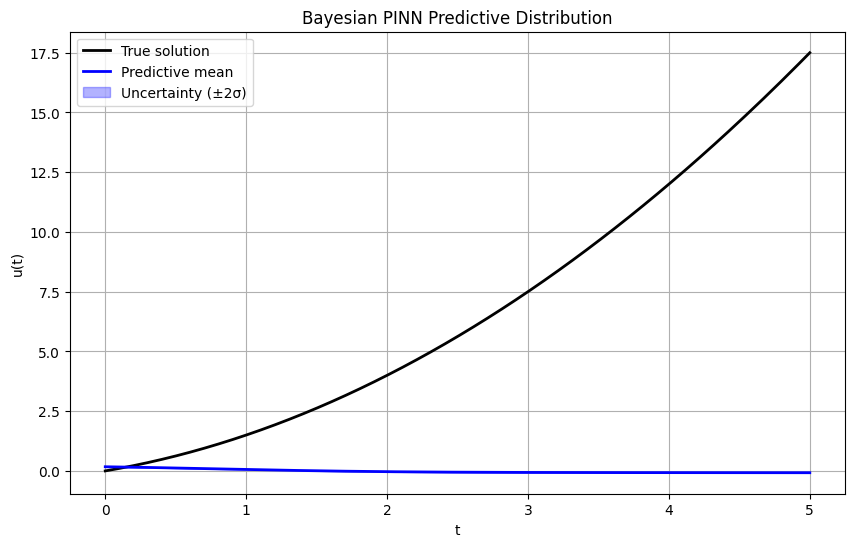

In [22]:
t_test = torch.linspace(0., 5., 200).view(-1, 1)


preds = []
net = PlainNN()


for i in range(100):  # 100 posterior samples
    sampled_model = pyro.random_module("net", net, mcmc.get_samples())()  
    with torch.no_grad():
        u_pred = sampled_model(t_test)
        preds.append(u_pred.squeeze())

# Stack predictions → shape = [100, 200]

preds = torch.stack(preds)


u_mean = preds.mean(dim=0)
u_std = preds.std(dim=0)

# Step 6: Compute true solution
u_true = 0.5 * t_test.squeeze()**2 + t_test.squeeze()



plt.figure(figsize=(10, 6))
plt.plot(t_test.squeeze(), u_true, label="True solution", color="black", linewidth=2)
plt.plot(t_test.squeeze(), u_mean, label="Predictive mean", color="blue", linewidth=2)
plt.fill_between(t_test.squeeze(),u_mean - 2 * u_std,u_mean + 2 * u_std,alpha=0.3,label="Uncertainty (±2σ)",color="blue")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.legend()
plt.title("Bayesian PINN Predictive Distribution")
plt.grid(True)
plt.show()

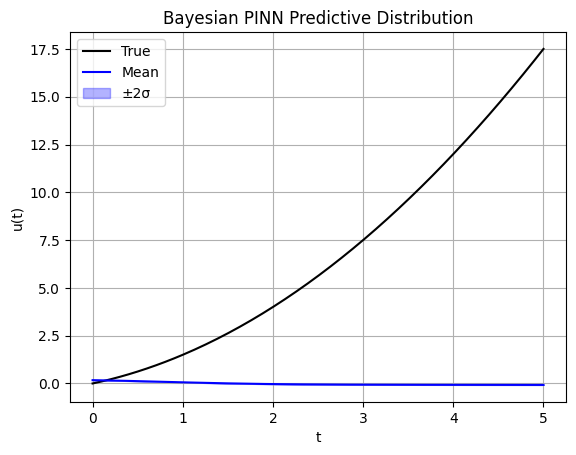

In [ ]:
# # Test inputs
# t_test = torch.linspace(0., 5., 200).view(-1, 1)

# # Predictive distribution from posterior samples
# net = PlainNN()
# samples = mcmc.get_samples()

# preds = []
# for i in range(50):
#     sampled_net = pyro.random_module("net", net, {k: v[i] for k, v in samples.items()})()
#     preds.append(sampled_net(t_test).squeeze())

# preds = torch.stack(preds)
# u_mean = preds.mean(0)
# u_std = preds.std(0)

# # Ground truth
# u_true = 0.5 * t_test.squeeze()**2 + t_test.squeeze()

# # Plot

# u_mean_plot = u_mean.detach().numpy()
# u_std_plot = u_std.detach().numpy()


# plt.plot(t_test.squeeze(), u_true, label="True", color="black")
# plt.plot(t_test.squeeze(), u_mean_plot, label="Mean", color="blue")
# plt.fill_between(t_test.squeeze(), u_mean_plot - 2*u_std_plot, u_mean_plot + 2*u_std_plot,color="blue", alpha=0.3, label="±2σ")
# plt.xlabel("t")
# plt.ylabel("u(t)")
# plt.title("Bayesian PINN Predictive Distribution")
# plt.legend()
# plt.grid(True)
# plt.show()

In [31]:
posterior_samples = mcmc.get_samples()

mean_w1 = posterior_samples["net$$$layer1.weight"].mean(0)
std_w1  = posterior_samples["net$$$layer1.weight"].std(0)

print(mean_w1.shape)

mean_b1 = posterior_samples["net$$$layer1.bias"].mean(0)
std_b1 = posterior_samples["net$$$layer1.bias"].std(0)

print(mean_b1.shape)

mean_w2 = posterior_samples["net$$$layer2.weight"].mean(0)
std_w2  = posterior_samples["net$$$layer2.weight"].std(0)

print(mean_w2.shape)

mean_b2 = posterior_samples["net$$$layer2.bias"].mean(0)
std_b2 = posterior_samples["net$$$layer2.bias"].std(0)

print(mean_b2.shape)

mean_w3 = posterior_samples["net$$$layer3.weight"].mean(0)
std_w3  = posterior_samples["net$$$layer3.weight"].std(0)

print(mean_w3.shape)

mean_b3 = posterior_samples["net$$$layer3.bias"].mean(0)
std_b3 = posterior_samples["net$$$layer3.bias"].std(0)

print(mean_b3.shape)




torch.Size([50, 1])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([1, 50])
torch.Size([1])


In [37]:
def model_pinn_data(t_obs,u_obs,t_pde, t_ic):
    t_pde = t_pde.detach().requires_grad_(True)

    posterior_samples = mcmc.get_samples()
    
    net = PlainNN()
    
    sample_idx = pyro.sample("theta_idx", dist.Categorical(torch.ones(len(posterior_samples["net$$$layer1.weight"]))))
    sample = {k: v[sample_idx] for k, v in posterior_samples.items()}

    # Sample a Bayesian NN with sampled parameters
    sampled_net = pyro.random_module("net", net, sample)()
    
    # Forward pass
    u_pred_pde = sampled_net(t_pde)
    du_dt = torch.autograd.grad(u_pred_pde,t_pde,grad_outputs=torch.ones_like(u_pred_pde),create_graph=True)[0]
    residual_pde = du_dt - t_pde

    u_pred_ic = sampled_net(t_ic)
    residual_ic = u_pred_ic

    u_pred = sampled_net(t_obs)

    # Likelihoods
    with pyro.plate("pde_plate", len(t_pde)):
        pyro.sample("pde_obs", dist.Normal(0., 0.5), obs=residual_pde.squeeze())

    with pyro.plate("ic_plate", len(t_ic)):
        pyro.sample("ic_obs", dist.Normal(0., 0.5), obs=residual_ic.squeeze())

    with pyro.plate("data", len(t_obs)):
        pyro.sample("obs", dist.Normal(u_pred.squeeze(), 0.1), obs=u_obs.squeeze())

In [39]:
nuts2 = NUTS(model_pinn_data)
mcmc2 = MCMC(nuts2, num_samples=50, warmup_steps=10)
mcmc2.run(t_obs, u_obs,t_pde,t_ic)

Warmup:   0%|          | 0/60 [00:00, ?it/s]/home/soumik/.local/lib/python3.10/site-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
Sample: 100%|██████████| 60/60 [00:00, 3206.61it/s, step size=1.00e+00, acc. prob=1.000]
